In this notebook we will read output binary files from a montecarlo simulation of a SU(2) theory with an adjoint Higgs. The first cell is for reading and storing into arrays the measurements of the spectroscopical operators with quantum number J_p = 1_minus. There are 4 observable, one that we will call B, and other three, that we will call T_1,T_2 and T_3. There are 5 smearing levels, and 3 spatial directions. The operator B has a small momentum in the z direction: P_z= 2\pi/N_z

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyhmc as phmc

import struct
Nt=8
w, h = 3, Nt
n_smear = 6
n_op = 4
n_meas = 1000
B = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
T1 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
T2 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
T3 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]
b_l = w * 8
ck = b_l*Nt*n_op
Sm_ck = ck*n_smear


#B =list(range(Nt))
with  open("O1minus_output_files/output_Nt8_Nx8_Ny8_Nz8_B4.000000_K2.000000_L1.000000.bin","rb") as f:
    fileContent =f.read()
    for n in range(n_meas):
        for ns in range(n_smear):
            #print(ns)
            for t in range(Nt):
                B[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+b_l*t:(Sm_ck*n)+(ck*ns)+(t+1)*b_l])
                T1[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt)+(t+1)*b_l])
                T2[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+(t+1)*b_l])
                T3[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+(t+1)*b_l])
    
       

#print(B)        
#print(T1[0][Nt-1][2])
#print(T2[0][Nt-1][2])
#print(T3[0][Nt-1][2])

Now we will calculate the correlator, for every measurement. The correlators are obtained as
C(t) = Sum_t' Sum_k O_k(t') O_k(t+t') We divide the transverse and the longitudinal part.

In [2]:
C = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
C_tr = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
C_par = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
#C1 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
#C2 = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]
#C3 = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]

for n in range(n_meas):
    for ns in range(n_smear):
        for t in range(Nt):
            for t_pr in range(Nt):
                for k in range(2):
                    C[n][ns][t] += B[n][ns][t_pr][k]*B[n][ns][(t_pr+t)%Nt][k]
                    C_tr[n][ns][t] += B[n][ns][t_pr][k]*B[n][ns][(t_pr+t)%Nt][k]
                    #C1[n][ns][t] += T1[n][ns][t_pr][k]*T1[n][ns][(t_pr+t)%Nt][k]
                    #C2[n][ns][t] += T2[n][ns][t_pr][k]*T2[n][ns][(t_pr+t)%Nt][k]
                    #C3[n][ns][t] += T3[n][ns][t_pr][k]*T3[n][ns][(t_pr+t)%Nt][k]
                C_par[n][ns][t] += B[n][ns][t_pr][2]*B[n][ns][(t_pr+t)%Nt][2]
                C[n][ns][t] += B[n][ns][t_pr][2]*B[n][ns][(t_pr+t)%Nt][2]
#print(C[2000])    

Now we will do statistical analysis to the correlators. We will obtain averages and error for the correlators, calculating autocorrelation as well.

In [3]:
C_res = [0 for y in range(3)]
#Cv = [0 for n in range(n_meas)]
C_res[0] =  np.mean(C,axis =0 )
C_res[1] = np.std(C,axis =0 )
C_res[2] = [[0 for t in range(Nt)]for sm in range(n_smear) ] 

C_tr_res = [0 for y in range(3)]
#Cv = [0 for n in range(n_meas)]
C_tr_res[0] =  np.mean(C_tr,axis =0 )
C_tr_res[1] = np.std(C_tr,axis =0 )
C_tr_res[2] = [[0 for t in range(Nt)]for sm in range(n_smear) ] 

C_par_res = [0 for y in range(3)]
#Cv = [0 for n in range(n_meas)]
C_par_res[0] =  np.mean(C_par,axis =0 )
C_par_res[1] = np.std(C_par,axis =0 )
C_par_res[2] = [[0 for t in range(Nt)]for sm in range(n_smear) ] 

#print(C_res[1])

for ns in range(n_smear):
    for t in range(Nt):
        vec = []
        for n in range(n_meas):
            vec.append(float(C[n][ns][t]))
        C_res[2][ns][t] = phmc.integrated_autocorr6(np.array(vec),6)
        #print(C_res[2][ns][t])
        C_res[1][ns][t] = C_res[1][ns][t]* np.sqrt(C_res[2][ns][t]/n_meas)             
for ns in range(n_smear):
    for t in range(Nt):
        vec = []
        for n in range(n_meas):
            vec.append(float(C_tr[n][ns][t]))
        C_tr_res[2][ns][t] = phmc.integrated_autocorr6(np.array(vec),6)
        #print(C_res[2][ns][t])
        C_tr_res[1][ns][t] = C_tr_res[1][ns][t]* np.sqrt(C_tr_res[2][ns][t]/n_meas)  

for ns in range(n_smear):
    for t in range(Nt):
        vec = []
        for n in range(n_meas):
            vec.append(float(C_par[n][ns][t]))
        C_par_res[2][ns][t] = phmc.integrated_autocorr6(np.array(vec),6)
        #print(C_res[2][ns][t])
        C_par_res[1][ns][t] = C_par_res[1][ns][t]* np.sqrt(C_par_res[2][ns][t]/n_meas)             

print(C_res[2][4][1])        

[3.91384507]


Now we plot the correlators for the transverse part of the operator B.

[0.6634341390967637, 0.2888654139349699, 0.14961102954041702, 0.09156136813327362, 0.07345467205104385, 0.09156136813327362, 0.14961102954041702, 0.2888654139349699]


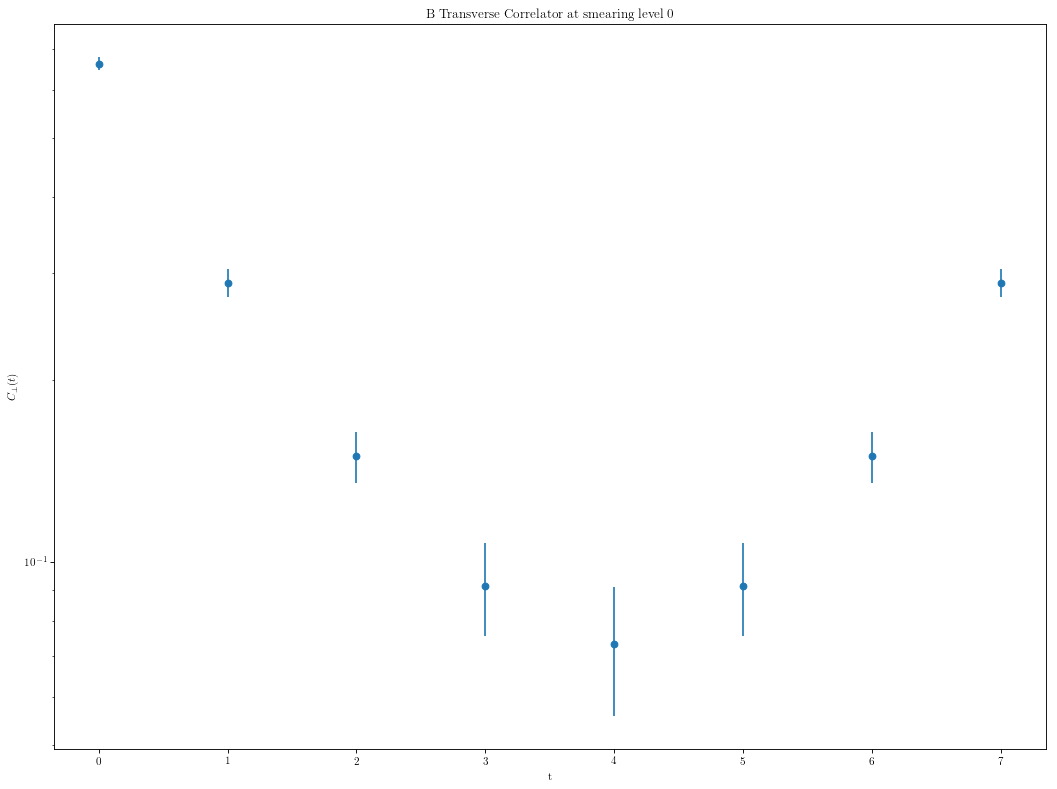

In [39]:
T = list(range(Nt))
C_tr_avg = list(range(Nt))
C_tr_err = list(range(Nt))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for ns in range(1):
    for t in range(Nt):
        C_tr_avg[t] = C_res[0][ns][t]
        C_tr_err[t] = C_res[1][ns][t]
    
    print(C_tr_avg)
    
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(T,C_tr_avg,C_tr_err,fmt='o',label = 'data')
    plt.xlabel('t')
    plt.ylabel(r'$C_\perp(t)$')
    plt.yscale("log")
    plt.title("B Transverse Correlator at smearing level %d" % (ns))
    plt.savefig("B_transverse.jpg")

We plot here the correlator of the parallel part of the operator B.

[0.018028283948501606, -0.00018980791596135674, -0.00021821734253658836, -0.00014093120253775573, -0.0002975046322266235, -0.0001409312025377558, -0.00021821734253658838, -0.00018980791596135657]


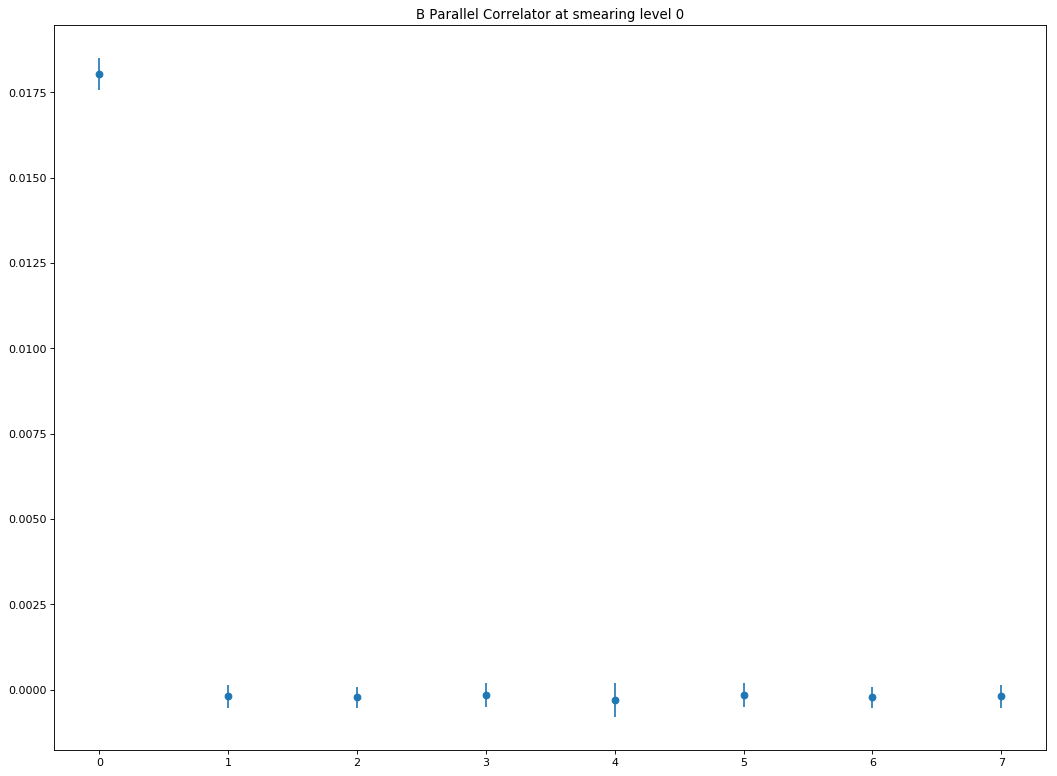

In [5]:
T = list(range(Nt))
C_par_avg = list(range(Nt))
C_par_err = list(range(Nt))

for ns in range(1):
    for t in range(Nt):
        C_par_avg[t] = C_par_res[0][ns][t]
        C_par_err[t] = C_par_res[1][ns][t]
    
    print(C_par_avg)
    
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(T,C_par_avg,C_par_err,fmt='o',label = 'data')
    #plt.yscale("log")
    plt.title("B Parallel Correlator at smearing level %d" % (ns))
    plt.savefig("B_parallel.jpg")

[0.8314687020762188, 0.6579220942186224, 0.4910293522465333, 0.2203409282621757, -0.22034092826217574, -0.49102935224653327, -0.6579220942186225]
[0.05870113990691421, 0.11013065087813365, 0.19896635145640845, 0.29609009226071914, 0.29609009226071914, 0.19896635145640845, 0.11013065087813366]


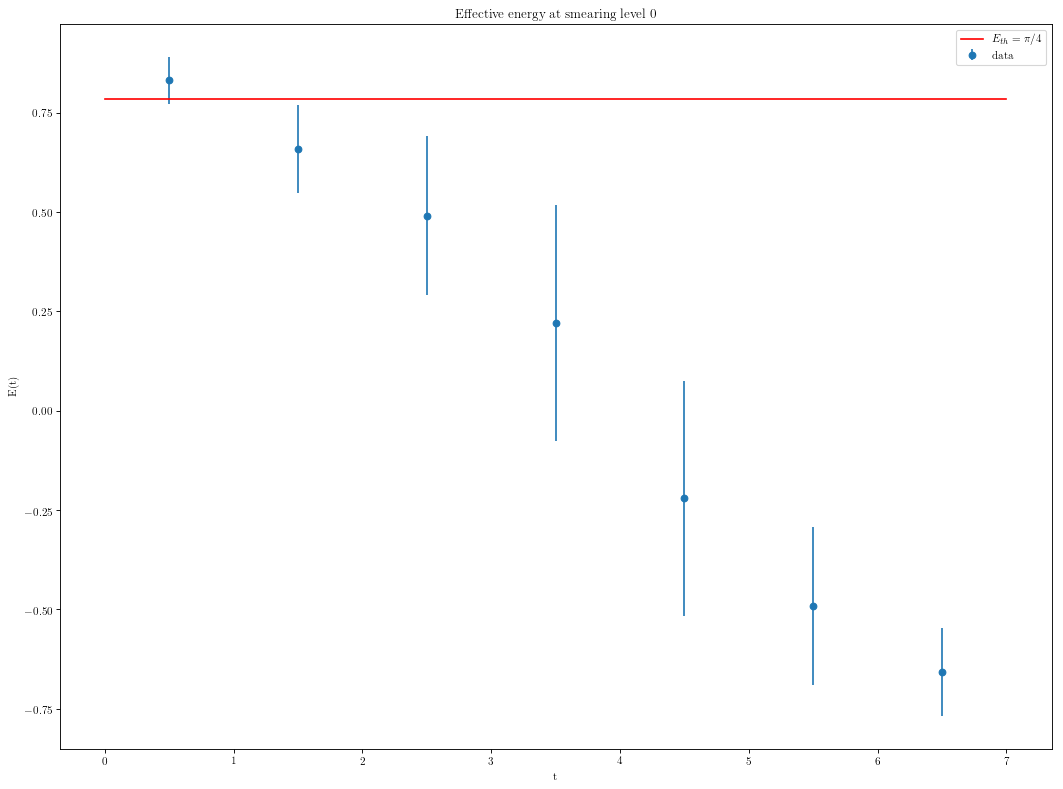

In [37]:
Tm = list(range(Nt-1))
E = list(range(Nt-1))
E_unc = list(range(Nt-1))

x = np.arange(8)
E_p= np.pi/4+(x-x)

for ns in range(1):
    for t in range(Nt-1):
        Tm[t] = t +0.5
        E[t] = np.log(C_tr_avg[t]/C_tr_avg[t+1])
        E_unc[t] = np.sqrt( (C_tr_err[t]/C_tr_avg[t])**2 + (C_tr_err[t+1]/C_tr_avg[t+1])**2 )

        
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(Tm, E,E_unc,fmt='o',label='data')
    plt.plot(x,E_p,'-r',label=r'$E_{th}=\pi/4$')
    plt.xlabel("t")
    plt.ylabel("E(t)")
    #plt.yscale("log")
    plt.legend()
    plt.title("Effective energy at smearing level %d" % (ns))
    plt.savefig('effective_energy.jpg')
    
print(E)
print(E_unc)